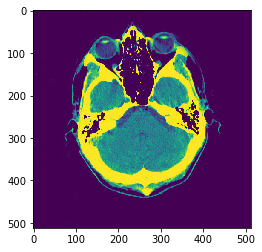

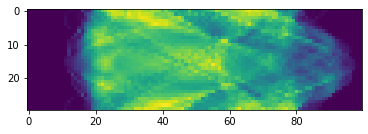

interactive(children=(IntSlider(value=0, description='x', max=30), Output()), _dom_classes=('widget-interact',…

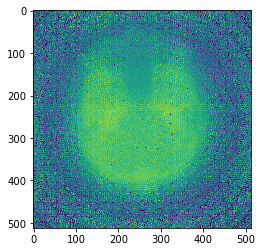

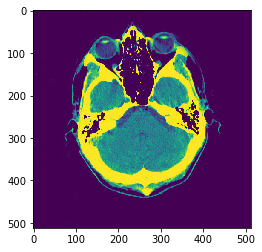

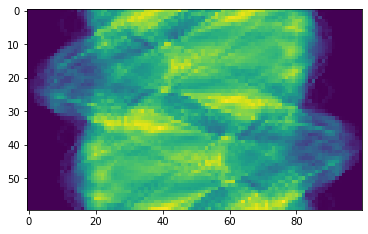

interactive(children=(IntSlider(value=0, description='x', max=60), Output()), _dom_classes=('widget-interact',…

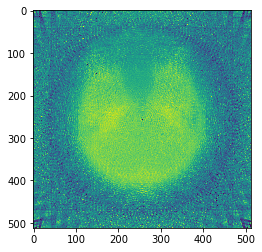

In [2]:
from abc import abstractmethod

from bresenham import bresenham
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from ipykernel.pylab.backend_inline import flush_figures
from skimage import io

#------------------------- CT "abstract" class
class CT:
    def __init__(self, filepath, withAnimation):
        self.imgToProcess = self.readProcessedImage(filepath)
        self.showImgToProcess()
        self.sinogram = None
        self.resultImage = None
        self.mapOfTransitions = None
        self.circleCoords = self.computeCircleEquation()
        self.withAnimation = withAnimation
        self.resultStepByStep = None
        self.mapOfTransitionsStepByStep = None

    @abstractmethod
    def transformSinogramToResultImage(self, angleInterval, angularExtent):
        pass

    def doCT(self, angleInterval, angularExtent, detectorsNumber):
        self.createSinogram(angleInterval, angularExtent, detectorsNumber)
        self.drawSinogram()
        self.transformSinogramToResultImage(angleInterval, angularExtent)
        self.divideByTransitionNumber()
        self.drawResultImage()

    def addLineToResult(self, hPos, dPos, value):
        transitionPoints = list(bresenham(hPos[0], hPos[1], dPos[0], dPos[1]))
        for point in transitionPoints:
            if 0 <= point[0] < self.imgToProcess.shape[0] and 0 <= point[1] < self.imgToProcess.shape[1]:
                self.mapOfTransitions[point[0]][point[1]] += 1
                self.resultImage[point[0]][point[1]] += value

    def divideByTransitionNumber(self):
        for i in range(self.resultImage.shape[0]):
            for j in range(self.resultImage.shape[1]):
                if self.mapOfTransitions[i][j] != 0:
                    self.resultImage[i][j] /= self.mapOfTransitions[i][j]
                else:
                    self.resultImage[i][j] = 0

    def computeDetectedValue(self, hPos, dPos):
        transitionPoints = list(bresenham(hPos[0], hPos[1], dPos[0], dPos[1]))
        sumOfBrightness = 0
        numberOfIncludedPixels = 0
        for point in transitionPoints:
            if 0 < point[0] < self.imgToProcess.shape[0] and 0 < point[1] < self.imgToProcess.shape[1]:
                numberOfIncludedPixels += 1
                sumOfBrightness += self.imgToProcess[point[0]][point[1]]
        if numberOfIncludedPixels > 0:
            return sumOfBrightness / numberOfIncludedPixels
        return 0

    def readProcessedImage(self, filepath):
        return mpimg.imread(filepath)

    def drawResultImage(self):
        plt.imshow(self.resultImage)
        plt.show()

    def drawSinogram(self):
        plt.imshow(self.sinogram)
        plt.show()

    def showImgToProcess(self):
        plt.imshow(self.imgToProcess)
        plt.show()

    def computeCircleEquation(self):
        coords = list(map(lambda x: x / 2, self.imgToProcess.shape))
        radius = (coords[0] ** 2 + coords[1] ** 2) ** 0.5
        return {'x': coords[0], 'y': coords[1], 'r': radius}

    def getDevicePosition(self, alpha):
        x = self.circleCoords['x'] + self.circleCoords['r'] * np.cos(alpha)
        y = self.circleCoords['y'] + self.circleCoords['r'] * np.sin(alpha)
        return [int(x), int(y)]

    @abstractmethod
    def createSinogram(self, angleInterval, angularExtent, detectorsNumber):
        pass
    
    def on_change(self, x=0):
        io.imshow(self.resultStepByStep[x])
        flush_figures()
        
    def normalizeStep(self, step):
        for x in range(len(self.mapOfTransitionsStepByStep[step])):
            for y in range(len(self.mapOfTransitionsStepByStep[step][x])):
                if self.mapOfTransitionsStepByStep[step][x][y] != 0:
                    self.resultStepByStep[step][x][y] /= self.mapOfTransitionsStepByStep[step][x][y]


#------------------------- Conical CT class
class ConicalCT(CT):
    def __init__(self, filepath, withAnimation=False):
        super().__init__(filepath, withAnimation)

    def transformSinogramToResultImage(self, angleInterval, angularExtent):
        self.resultImage = np.zeros(self.imgToProcess.shape)
        self.mapOfTransitions = np.zeros(self.imgToProcess.shape)
        if self.withAnimation:
            self.resultStepByStep = [np.zeros(self.imgToProcess.shape)]
            self.mapOfTransitionsStepByStep = [np.zeros(self.imgToProcess.shape)]
        for i in range(self.sinogram.shape[0]):
            headerPosition = self.getDevicePosition(angleInterval * i)
            for j in range(self.sinogram.shape[1]):
                detectorPosition = self.getDevicePosition(
                    angleInterval * i + np.pi - angularExtent / 2 + j * angularExtent / self.sinogram.shape[1])
                self.addLineToResult(headerPosition, detectorPosition, self.sinogram[i][j])
            if self.withAnimation:
                self.resultStepByStep.append(self.resultImage.copy())
                self.normalizeStep(i)
                self.mapOfTransitionsStepByStep.append(self.mapOfTransitions.copy())
        if self.withAnimation:
            widgets.interact(self.on_change, x=(0,len(self.resultStepByStep) - 1, 1))

    def createSinogram(self, angleInterval, angularExtent, detectorsNumber):
        self.sinogram = np.zeros((int(2 * np.pi / angleInterval), detectorsNumber))
        for headerAngle, i in zip(np.arange(0, 2 * np.pi, angleInterval), range(int(2 * np.pi / angleInterval))):
            headerPosition = self.getDevicePosition(headerAngle)
            for detectorAngle, j in zip(np.arange(headerAngle + np.pi - angularExtent / 2,
                                                  headerAngle + np.pi + angularExtent / 2,
                                                  angularExtent / detectorsNumber), range(detectorsNumber)):
                detectorPosition = self.getDevicePosition(detectorAngle)
                self.sinogram[i][j] = self.computeDetectedValue(headerPosition, detectorPosition)


#------------------------- Parallel CT class
class ParallelCT(CT):
    def __init__(self, filepath, withAnimation=False):
        super().__init__(filepath, withAnimation)

    def transformSinogramToResultImage(self, angleInterval, angularExtent):
        self.resultImage = np.zeros(self.imgToProcess.shape)
        self.mapOfTransitions = np.zeros(self.imgToProcess.shape)
        if self.withAnimation:
            self.resultStepByStep = [np.zeros(self.imgToProcess.shape)]
            self.mapOfTransitionsStepByStep = [np.zeros(self.imgToProcess.shape)]
        for i in range(self.sinogram.shape[0]):
            for j in range(self.sinogram.shape[1]):
                emitterPosition = self.getDevicePosition(angleInterval * i - angularExtent / 2 + j * angularExtent / self.sinogram.shape[1])
                detectorPosition = self.getDevicePosition(angleInterval * i + np.pi + angularExtent / 2 - j * angularExtent / self.sinogram.shape[1])
                self.addLineToResult(emitterPosition, detectorPosition, self.sinogram[i][j])
            if self.withAnimation:
                self.resultStepByStep.append(self.resultImage.copy())
                self.normalizeStep(i)
                self.mapOfTransitionsStepByStep.append(self.mapOfTransitions.copy())
        if self.withAnimation:
            widgets.interact(self.on_change, x=(0,len(self.resultStepByStep) - 1, 1))

    def createSinogram(self, angleInterval, angularExtent, detectorsNumber):
        self.sinogram = np.zeros((int(np.pi / angleInterval), detectorsNumber))
        for centralPoint, i in zip(np.arange(0, np.pi, angleInterval), range(int(np.pi / angleInterval))):
            for j in range(detectorsNumber):
                emitterAngle = self.getDevicePosition(centralPoint - angularExtent / 2 + j * angularExtent / detectorsNumber)
                detectorPosition = self.getDevicePosition(centralPoint + np.pi + angularExtent / 2 - j * angularExtent / detectorsNumber)
                self.sinogram[i][j] = self.computeDetectedValue(emitterAngle, detectorPosition)
    
           
# to receive pretty good image for ConicalCT you have to use angular extend close to 180 degree              
p = ParallelCT('ct_scan.png', withAnimation=True)
p.doCT(np.pi / 30, np.pi/2.3, 100)
p = ConicalCT('ct_scan.png' , withAnimation=True)
p.doCT(np.pi / 30, np.pi/1.2, 100)